In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

from google.colab import drive
drive.mount("/content/drive")

CONTENT_IMG = '/content/drive/My Drive/images/content/neckarfront.jpeg'
STYLE_IMG_PATH = '/content/drive/My Drive/images/style'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
def load_img(path):
  print('Loading image...')
  img = tf.io.read_file(path)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)
  return img

In [3]:
vgg19 = tf.keras.applications.VGG19(include_top=False, pooling='avg')
vgg19.trainable = False

In [4]:
content_img = load_img(CONTENT_IMG)
style_images = {}

for root, dir, files in os.walk(STYLE_IMG_PATH):
  for img in files:
    style_images[img.split('.')[0]] = load_img(os.path.join(root, img))

print(style_images.keys())
style_img = style_images['VanGogh']

Loading image...
Loading image...
Loading image...
Loading image...
Loading image...
Loading image...
dict_keys(['Turner', 'VanGogh', 'EdvardMunch', 'Picasso', 'Kandinsky'])


In [5]:
def preprocess_img(img):
  img = tf.image.resize(img, size=(224, 224))
  img = tf.expand_dims(img, 0)
  img = tf.convert_to_tensor(img)
  return img

In [6]:
def reverse_img(tensor):
  tensor = tensor[0]
  return tensor.numpy()


In [7]:
def deprocess_image(x):

  x = reverse_img(x) * 255
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]
  x = np.clip(x, 0, 255).astype("uint8")
  return x


In [8]:
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 
                      'block4_conv1', 'block5_conv1']
content_layers = ['block4_conv2']

In [9]:
def get_model(layers, model):
  outputs = [model.get_layer(layer).output for layer in layers]
  model = tf.keras.Model([model.input], outputs)
  return model

In [10]:
nst_model = get_model(style_layers + content_layers, vgg19)
nst_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [11]:
style_extractor_model = get_model(style_layers, vgg19)
content_extractor_model = get_model(content_layers, vgg19)

In [12]:
style_targets = style_extractor_model(preprocess_img(style_img))
content_targets = content_extractor_model(preprocess_img(content_img))

In [13]:
def gram_matrix(input):
  return  tf.matmul(input, input, transpose_a = True)

def content_loss(original, target):
  return 0.5 * tf.reduce_sum(tf.square(original - target))

def style_loss(original, target):
  gram_original = gram_matrix(original)
  gram_target = gram_matrix(target)
  _, height, width, _ = original.get_shape().as_list()
  
  channels = 3
  res = (tf.square(gram_original - gram_target))/(4.0 * (channels ** 2) * ((height * width) **2))
  return tf.reduce_sum(res)

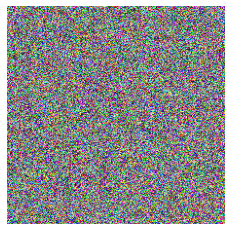

In [14]:
white_noise = tf.random.uniform((224, 224, 3), minval=0, maxval=1, dtype='float32')
plt.imshow(white_noise)
plt.axis('off')
white_noise = preprocess_img(white_noise)
target = tf.Variable(white_noise)

In [16]:
def optimize_step_content(target, loss_fn, opt, img_targets):
  with tf.GradientTape() as tape:
    outputs = nst_model(target)
    content_outputs = outputs[-1]
    loss = loss_fn(content_outputs, img_targets)
  grad = tape.gradient(loss, target)
  opt.apply_gradients([(grad, target)])
  target.assign(tf.clip_by_value(target, clip_value_min=0.0, clip_value_max=1.0))
  return loss

In [17]:
def train_target(target, loss_fn, iters, img_targets, opt_type='adam'):
  if opt_type=='adam':
    opt = tf.optimizers.Adam(learning_rate=0.02)
  plt.figure(figsize=(20, 10))
  for i in range(iters):
    loss = optimize_step_content(target, loss_fn, opt, img_targets)
    if(i % 100 == 0):
      plt.subplot(2, 5, i/100+1)
      plt.imshow(target[0])
      plt.axis('off')
      plt.title('Iteration: {}'.format(i))
  # plt.savefig('content_representation', transparent=True)

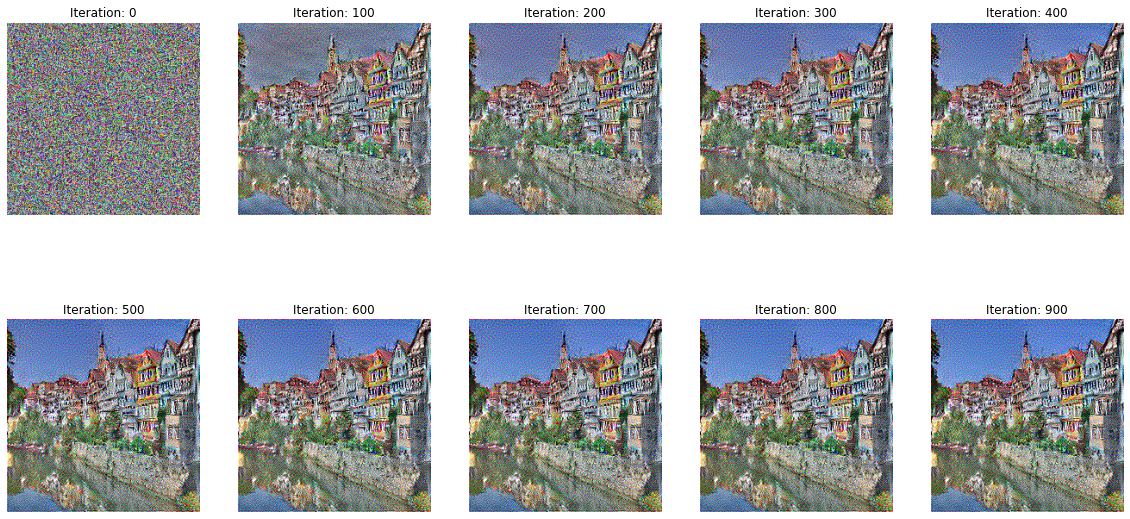

In [18]:
train_target(target, content_loss, 1000, content_targets)

(-0.5, 223.5, 223.5, -0.5)

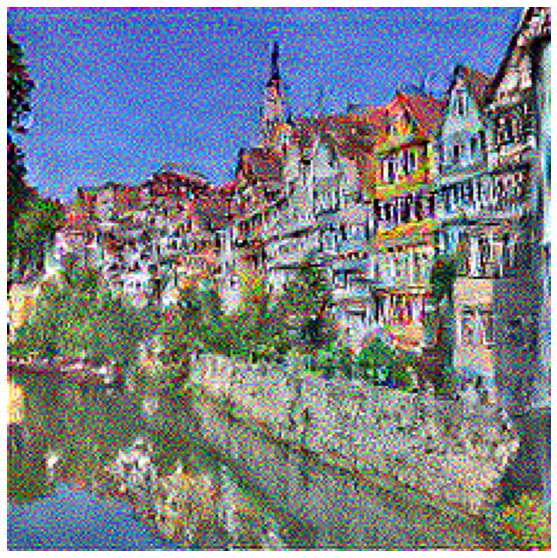

In [19]:
plt.figure(figsize=(10, 10))
plt.imshow(target[0])
plt.axis('off')

In [24]:
style_target = tf.Variable(white_noise)

In [25]:
def reconstruct_style(target, iters, layers, style_targets):
  opt = tf.optimizers.Adam(learning_rate=0.02)
  plt.figure(figsize=(20, 10))
  for i in range(iters):
    with tf.GradientTape() as tape:
      outputs = nst_model(target)
      loss = [style_loss(outputs[i], style_targets[i]) for i in range(len(layers))]
      loss = tf.add_n(loss)
    grad = tape.gradient(loss, target)
    opt.apply_gradients([(grad, target)])
    target.assign(tf.clip_by_value(target, clip_value_min=0.0, clip_value_max=1.0))
    if(i %100 == 0):
      plt.subplot(2, 5, i/100 + 1)
      plt.imshow(target[0])
      plt.axis('off')
      plt.title('Iteration: {}'.format(i))
  # plt.savefig('style_representation', transparent=True)

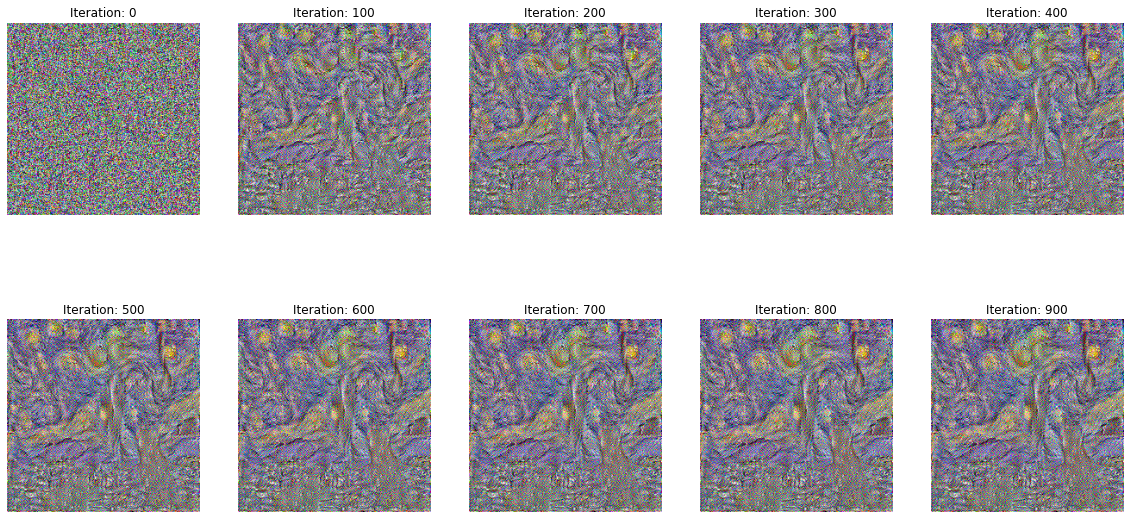

In [26]:
reconstruct_style(style_target, 1000, style_layers, style_targets)

(-0.5, 223.5, 223.5, -0.5)

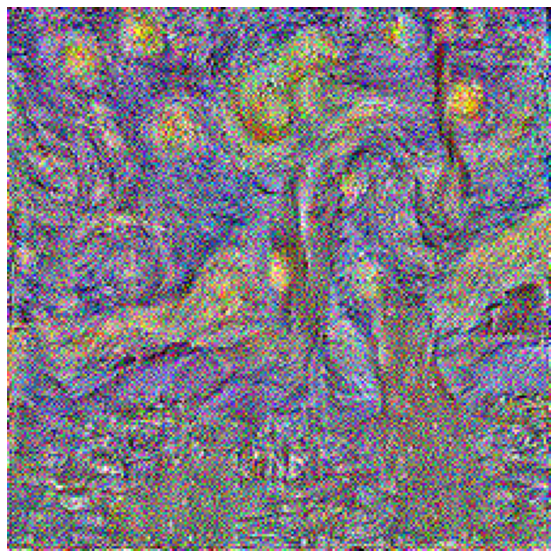

In [27]:
plt.figure(figsize=(10, 10))
plt.imshow(style_target[0])
plt.axis('off')

In [28]:
nst_target = tf.Variable(white_noise)

In [29]:
ratio = 1/len(style_layers)
style_weights = np.repeat(ratio, len(style_layers))

In [30]:
def total_loss(target, style_weights, beta=1e4, alpha=1e2, subset=5):
  num_style_layers = len(style_layers[:subset])
  num_content_layers = len(content_layers)
  outputs = nst_model(target)
  style_outputs = outputs[:num_style_layers]
  content_outputs = outputs[-1]

  loss_s = [style_loss(out, style_tar) for (out, style_tar) in zip(style_outputs, style_targets[:num_style_layers])]
  loss_s = tf.add_n([weight*ls for (weight, ls) in zip(style_weights, loss_s)])
  loss_s *= beta

  loss_c = tf.add_n([content_loss(out, content_tar) for (out, content_tar) in zip(content_outputs, content_targets)])
  loss_c *= alpha 
  
  loss = loss_s + loss_c
  return loss, loss_c, loss_s

In [31]:
def stylize(target, iters, style_weights, opt_type='adam', alpha=1e2, beta=1e4, subset=5, learn_rate=0.02):
  opt = tf.optimizers.Adam(learning_rate=learn_rate)
  for _ in range(iters):
    with tf.GradientTape() as tape:
      outputs = nst_model(target)
      loss, loss_c, loss_s = total_loss(target, style_weights, alpha=alpha, beta=beta, subset=subset)
    grad = tape.gradient(loss, target)
    opt.apply_gradients([(grad, target)])
    target.assign(tf.clip_by_value(target, clip_value_min=0.0, clip_value_max=1.0))

In [32]:
stylize(nst_target, 1000, style_weights) 

(-0.5, 223.5, 223.5, -0.5)

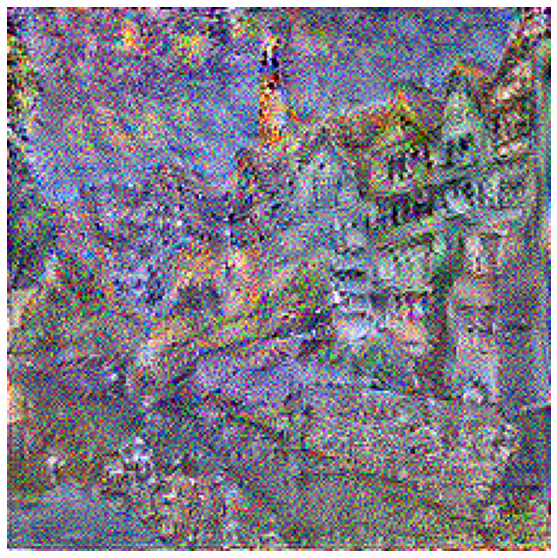

In [33]:
plt.figure(figsize=(10, 10))
plt.imshow(nst_target[0])
plt.axis('off')